In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [11]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc
from sqlalchemy.sql import label

In [12]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [13]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [14]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [15]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [16]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [22]:
# names for each table
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [25]:
engine.execute('SELECT * FROM station LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [26]:
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [53]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the data and precipitation scores

results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= '2017-01-01')

In [54]:
# create empty dict to populate
data = {'date': [], 'prcp': []}

# populate dict with rows from results
for row in results:
    data['date'].append(row.date)
    data['prcp'].append(row.prcp)

# create pandas df from dict
prcp17 = pd.DataFrame(data['prcp'], columns = ['prcp'], index = data['date'])
prcp17.head()


,prcp
2017-01-01,0.0
2017-01-02,0.0
2017-01-03,0.0
2017-01-04,0.0
2017-01-05,0.0


In [100]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp17.describe()

,prcp
count,1267.000000
mean,0.165927
std,0.453913
min,0.000000
25%,0.000000
50%,0.000000
75%,0.105000
max,6.250000


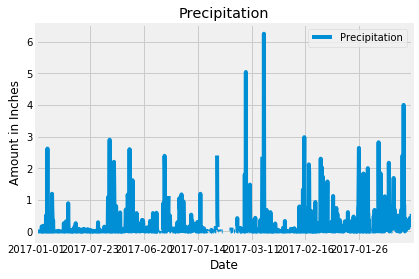

In [125]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp17.plot()
plt.xlabel("Date")
plt.ylabel("Amount in Inches")
plt.title("Precipitation")
plt.legend(["Precipitation"])
plt.show()


In [38]:
# Design a query to show how many stations are available in this dataset?
results = session.query(Station)
results.count()

9

In [39]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
desc_order = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc())
for result in desc_order:
    print(result)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [46]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

temperature = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs))
for result in temperature:
    print(result)

(53.0, 87.0, 73.09795396419437)


In [40]:
# Choose the station with the highest number of temperature observations.
obsv_num = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).first()
print(obsv_num)

('USC00519281', 2772)


In [77]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temps = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
    filter(Measurement.date > '2017-01-01').\
    order_by(Measurement.date).all()

df = pd.DataFrame(temps, columns=['Station', 'date', 'temp'])
df.set_index('Station', inplace=True)
df.head()

,date,temp
Station,,
USC00519397,2017-01-02,66.0
USC00513117,2017-01-02,66.0
USC00514830,2017-01-02,74.0
USC00519281,2017-01-02,70.0
USC00516128,2017-01-02,70.0


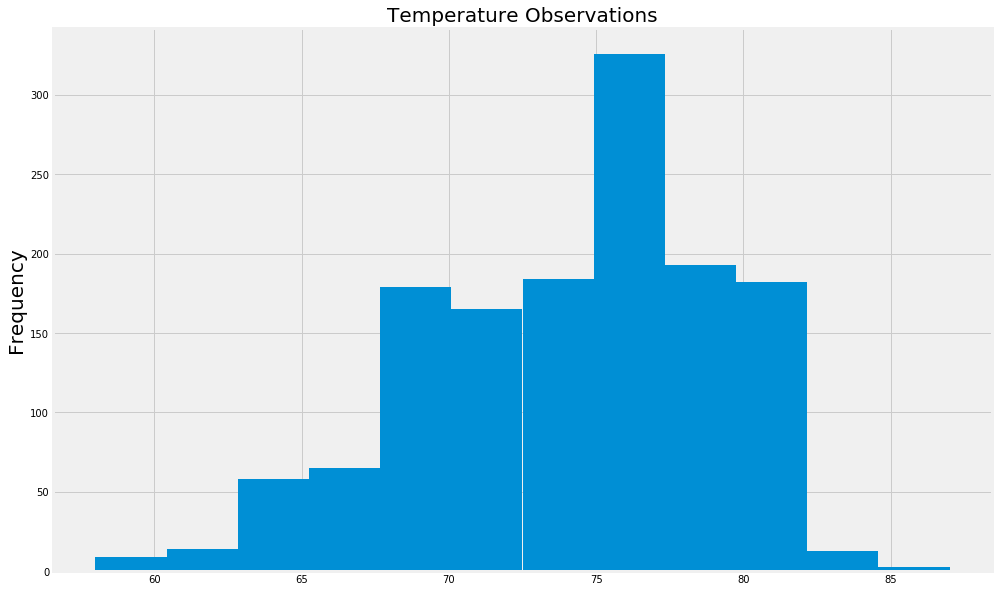

In [78]:
hist_plot = df['temp'].hist(bins=12, figsize=(15,10))
hist_plot.set_title('Temperature Observations', fontsize=20)
hist_plot.set_ylabel('Frequency', fontsize=20)
plt.show()

In [79]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [89]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

temperatures = (calc_temps('2017-02-28', '2017-03-05'))
labels = ['TMIN', 'TAVG', 'TMAX']
df = pd.DataFrame.from_records(temperatures, columns=labels)
df

,TMIN,TAVG,TMAX
0,64.0,72.027778,78.0


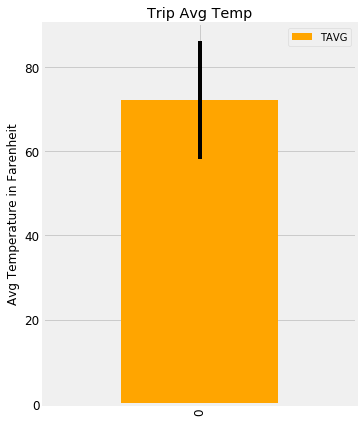

In [93]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

temp_chart = df[['TAVG']].plot(kind='bar', title ="Trip Avg Temp", figsize=(5, 7), legend=True, fontsize=12, grid=True, color='orange', yerr=14)
temp_chart.set_ylabel("Avg Temperature in Farenheit", fontsize=12)
plt.show()

In [94]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.

desc_order_rainfall = session.query(Measurement.station, func.sum(Measurement.prcp)).group_by(Measurement.station).order_by(func.count(Measurement.prcp).desc())
for result in desc_order_rainfall:
    print(result)

('USC00519281', 588.6399999999976)
('USC00513117', 382.61999999999847)
('USC00519397', 131.62000000000063)
('USC00519523', 295.67999999999944)
('USC00516128', 1068.0899999999956)
('USC00514830', 234.49000000000026)
('USC00511918', 92.68000000000006)
('USC00517948', 43.44000000000002)
('USC00518838', 70.87000000000005)


In [98]:
desc_order_rainfall = session.query(Measurement.station, Station.name, Station.elevation, Station.longitude, Station.latitude, func.sum(Measurement.prcp)).group_by(Measurement.station).order_by(func.count(Measurement.prcp).desc()).\
        filter(Measurement.date >= '2012-02-28').filter(Measurement.date <= '2012-03-05').all()
for result in desc_order_rainfall:
    print(result)

('USC00511918', 'WAIKIKI 717.2, HI US', 3.0, -157.8168, 21.2716, 6.840000000000001)
('USC00513117', 'WAIKIKI 717.2, HI US', 3.0, -157.8168, 21.2716, 52.11000000000001)
('USC00516128', 'WAIKIKI 717.2, HI US', 3.0, -157.8168, 21.2716, 92.88000000000004)
('USC00519281', 'WAIKIKI 717.2, HI US', 3.0, -157.8168, 21.2716, 99.71999999999998)
('USC00519397', 'WAIKIKI 717.2, HI US', 3.0, -157.8168, 21.2716, 10.620000000000001)
('USC00519523', 'WAIKIKI 717.2, HI US', 3.0, -157.8168, 21.2716, 26.280000000000005)
('USC00514830', 'WAIKIKI 717.2, HI US', 3.0, -157.8168, 21.2716, 0.27)
('USC00518838', 'WAIKIKI 717.2, HI US', 3.0, -157.8168, 21.2716, 34.56000000000001)
('USC00517948', 'WAIKIKI 717.2, HI US', 3.0, -157.8168, 21.2716, 0.0)


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


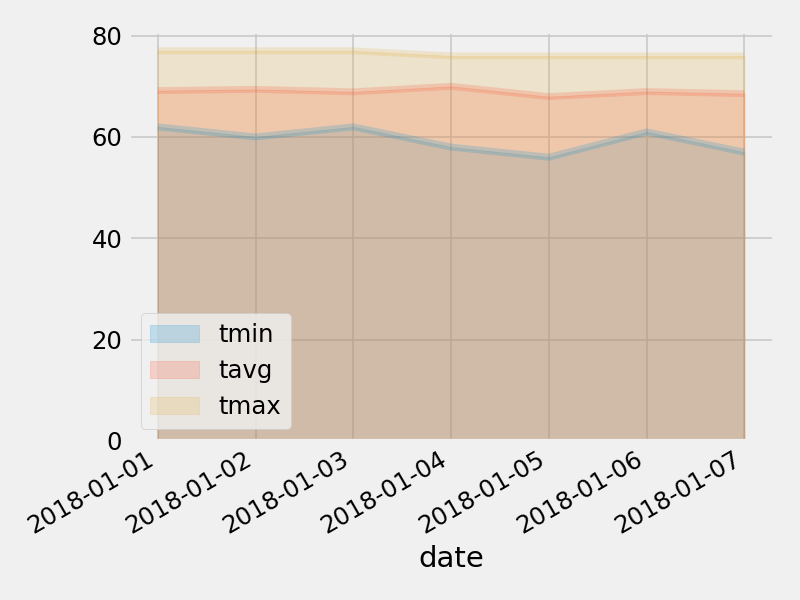

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
